In [2]:
# === Cell 1: Training Only ===

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# -------------------------------------------------
# 1. SimpleCNN 모델 정의 (원본과 동일)
# -------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*8*8, 256)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -------------------------------------------------
# 2. 훈련용 데이터로더 (블러 없이 ToTensor+Normalize)
# -------------------------------------------------
def get_train_loader(batch_size=128, num_workers=4):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2023, 0.1994, 0.2010)
        )
    ])
    train_ds = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    return DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# -------------------------------------------------
# 3. 학습 함수 (한 epoch)
# -------------------------------------------------
def train_one_epoch(model, loader, device, optimizer, criterion):
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()

# -------------------------------------------------
# 4. 메인: 모델 생성 → 학습 → 저장
# -------------------------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # (1) 데이터로더 준비
    train_loader = get_train_loader()

    # (2) 모델, 손실함수, 옵티마이저 선언
    net = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

    # (3) 학습: 총 10 epoch (필요에 따라 조정)
    num_epochs = 10
    for epoch in range(1, num_epochs+1):
        train_one_epoch(net, train_loader, device, optimizer, criterion)
        print(f"Epoch {epoch:02d}/{num_epochs} finished.")

    # (4) 학습 완료된 모델 저장
    torch.save(net.state_dict(), 'cifar10_simplecnn_clean.pth')
    print("✅ Model saved to cifar10_simplecnn_clean.pth")


Epoch 01/10 finished.
Epoch 02/10 finished.
Epoch 03/10 finished.
Epoch 04/10 finished.
Epoch 05/10 finished.
Epoch 06/10 finished.
Epoch 07/10 finished.
Epoch 08/10 finished.
Epoch 09/10 finished.
Epoch 10/10 finished.
✅ Model saved to cifar10_simplecnn_clean.pth


✅ Loaded model from cifar10_simplecnn_clean.pth
Blur σ=0.0 → Accuracy = 0.7253
Blur σ=0.5 → Accuracy = 0.6984
Blur σ=1.0 → Accuracy = 0.5977
Blur σ=1.5 → Accuracy = 0.5800
Blur σ=2.0 → Accuracy = 0.5731
Blur σ=2.5 → Accuracy = 0.5702


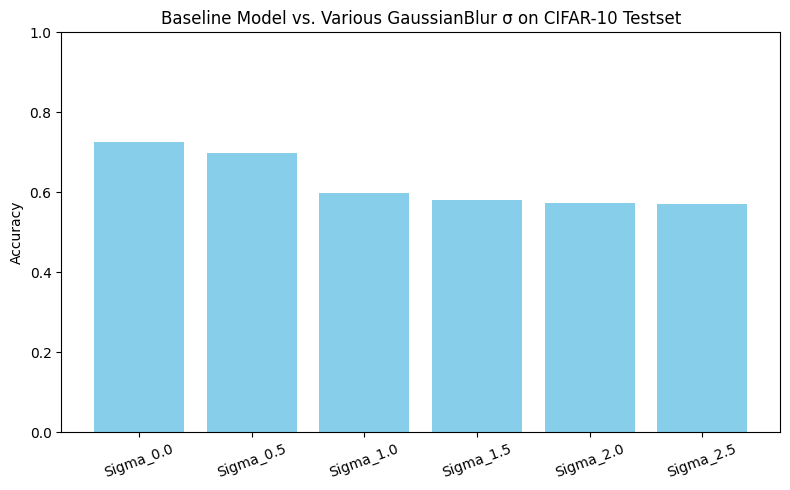

In [3]:
# === Cell 2: Evaluation Only ===

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

# -------------------------------------------------
# 1. SimpleCNN 클래스 정의 (Cell 1과 동일)
# -------------------------------------------------
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*8*8, 256)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -------------------------------------------------
# 2. 테스트용 데이터로더 생성 함수
#    - sigma = 0 → 블러 없이 평가
#    - sigma > 0 → GaussianBlur(kernel_size=3, sigma=sigma) 후 평가
# -------------------------------------------------
def get_test_loader(blur_sigma, batch_size=100, num_workers=4):
    # sigma == 0 이면 GaussianBlur 레이어를 건너뛸 transform으로 처리
    if blur_sigma <= 0:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010)
            )
        ])
    else:
        transform = transforms.Compose([
            transforms.GaussianBlur(kernel_size=3, sigma=blur_sigma),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010)
            )
        ])

    test_ds = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    return DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# -------------------------------------------------
# 3. 평가 함수: 전체 정확도만 계산
# -------------------------------------------------
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# -------------------------------------------------
# 4. 메인: 저장된 체크포인트 로드 → 여러 sigma 테스트 → 시각화
# -------------------------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # (1) 모델 생성 및 저장된 weight 불러오기
    net = SimpleCNN().to(device)
    checkpoint_path = 'cifar10_simplecnn_clean.pth'
    net.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded model from {checkpoint_path}")

    # (2) 비교할 sigma 리스트 정의 (0 포함)
    blur_sigmas = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]

    # (3) 결과를 저장할 dict
    results = {}

    for sigma in blur_sigmas:
        # loader 생성
        test_loader = get_test_loader(blur_sigma=sigma)
        acc = evaluate(net, test_loader, device)
        key = f"Sigma_{sigma:.1f}"
        results[key] = acc
        print(f"Blur σ={sigma:.1f} → Accuracy = {acc:.4f}")

    # (4) 시각화: Bar Chart
    labels = list(results.keys())
    accuracies = [results[k] for k in labels]

    plt.figure(figsize=(8,5))
    plt.bar(labels, accuracies, color='skyblue')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Baseline Model vs. Various GaussianBlur σ on CIFAR-10 Testset')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


✅ Loaded model from cifar10_simplecnn_clean.pth
SP amt=0.00 → Accuracy: 0.7253
SP amt=0.01 → Accuracy: 0.6380
SP amt=0.03 → Accuracy: 0.4943
SP amt=0.05 → Accuracy: 0.3724


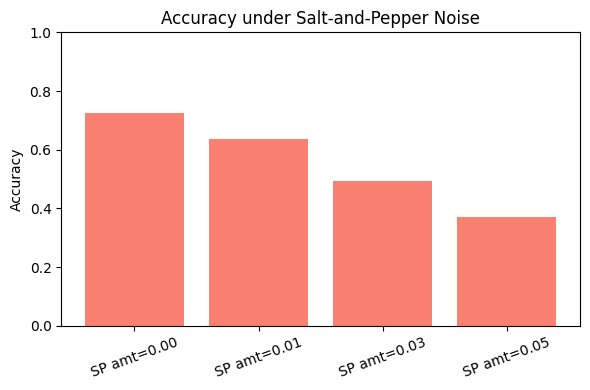

In [4]:
# === Cell 1: Salt-and-Pepper Noise Evaluation ===

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# ------------------------------
# 1. SimpleCNN 정의 (Training 때와 동일)
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*8*8, 256)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# ------------------------------
# 2. Salt-and-Pepper Noise 클래스 정의
# ------------------------------
class SaltPepperNoise(object):
    def __init__(self, amount=0.05):
        self.amount = amount  # 전체 픽셀 중 노이즈 적용 비율

    def __call__(self, tensor):
        """
        tensor: [C, H, W], 값 범위 [0,1]로 가정 (ToTensor() 직후)
        """
        c, h, w = tensor.shape
        num_pixels = int(self.amount * h * w)
        for _ in range(num_pixels):
            y = random.randint(0, h - 1)
            x = random.randint(0, w - 1)
            if random.random() < 0.5:
                tensor[:, y, x] = 0.0  # pepper (검정)
            else:
                tensor[:, y, x] = 1.0  # salt (흰색)
        return tensor

    def __repr__(self):
        return f"{self.__class__.__name__}(amount={self.amount})"


# ------------------------------
# 3. 테스트용 DataLoader 생성 함수 (Salt-and-Pepper)
# ------------------------------
def get_test_loader_saltpepper(sp_amount, batch_size=100, num_workers=4):
    """
    sp_amount <= 0: 노이즈 없이 평가
    sp_amount > 0: ToTensor → SaltPepperNoise(amount=sp_amount) → Normalize
    """
    if sp_amount <= 0:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            SaltPepperNoise(amount=sp_amount),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])

    test_ds = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    return DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# ------------------------------
# 4. 평가 함수 (전체 정확도 계산)
# ------------------------------
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


# ------------------------------
# 5. 메인: 저장된 모델 로드 → Salt-and-Pepper Noise 별 정확도 측정 → 시각화
# ------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # (1) 모델 생성 + 사전 학습된 가중치 로드
    net = SimpleCNN().to(device)
    checkpoint_path = 'cifar10_simplecnn_clean.pth'
    net.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded model from {checkpoint_path}")

    # (2) 테스트할 Salt-and-Pepper Noise 비율 리스트 정의
    sp_amounts = [0.0, 0.01, 0.03, 0.05]

    results_sp = {}
    for amt in sp_amounts:
        loader = get_test_loader_saltpepper(sp_amount=amt)
        acc = evaluate(net, loader, device)
        key = f"SP amt={amt:.2f}"
        results_sp[key] = acc
        print(f"{key} → Accuracy: {acc:.4f}")

    # (3) 결과 시각화
    labels_sp = list(results_sp.keys())
    accuracies_sp = [results_sp[k] for k in labels_sp]

    plt.figure(figsize=(6,4))
    plt.bar(labels_sp, accuracies_sp, color='salmon')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Accuracy under Salt-and-Pepper Noise')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


✅ Loaded model from cifar10_simplecnn_clean.pth
Affine (None) → Accuracy: 0.7253
deg=10, trans=(0.1, 0.1), scale=(0.9, 1.1), shear=5 → Accuracy: 0.4887
deg=15, trans=(0.2, 0.2), scale=(0.8, 1.2), shear=10 → Accuracy: 0.3551
deg=20, trans=(0.3, 0.3), scale=(0.7, 1.3), shear=15 → Accuracy: 0.2660


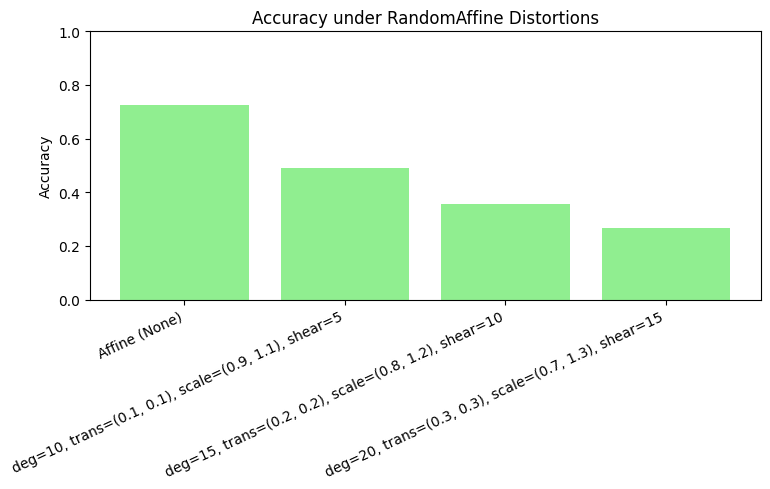

In [5]:
# === Cell 2: RandomAffine Distortion Evaluation ===

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict

# ------------------------------
# 1. SimpleCNN 정의 (Training 때와 동일)
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*8*8, 256)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# ------------------------------
# 2. 테스트용 DataLoader 생성 함수 (RandomAffine)
# ------------------------------
def get_test_loader_affine(affine_param, batch_size=100, num_workers=4):
    """
    affine_param: RandomAffine에 넘길 파라미터 딕셔너리
      예) {'degrees':15, 'translate':(0.1,0.1), 'scale':(0.9,1.1), 'shear':10}
      None이면 노이즈 없이 원본 평가
    """
    if affine_param is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])
    else:
        transform = transforms.Compose([
            transforms.RandomAffine(
                degrees=affine_param.get('degrees', 0),
                translate=affine_param.get('translate', (0, 0)),
                scale=affine_param.get('scale', (1.0, 1.0)),
                shear=affine_param.get('shear', 0)
            ),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])

    test_ds = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    return DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# ------------------------------
# 3. 평가 함수 (전체 정확도 계산)
# ------------------------------
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


# ------------------------------
# 4. 메인: 저장된 모델 로드 → RandomAffine 파라미터별 정확도 측정 → 시각화
# ------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # (1) 모델 생성 + 학습된 가중치 로드
    net = SimpleCNN().to(device)
    checkpoint_path = 'cifar10_simplecnn_clean.pth'
    net.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded model from {checkpoint_path}")

    # (2) 테스트할 RandomAffine 파라미터 리스트 정의
    affine_params = [
        None,  # 원본 (노이즈 없이)
        {'degrees': 10, 'translate': (0.1, 0.1), 'scale': (0.9, 1.1), 'shear': 5},
        {'degrees': 15, 'translate': (0.2, 0.2), 'scale': (0.8, 1.2), 'shear': 10},
        {'degrees': 20, 'translate': (0.3, 0.3), 'scale': (0.7, 1.3), 'shear': 15}
    ]

    results_affine = {}
    for p in affine_params:
        loader = get_test_loader_affine(affine_param=p)
        acc = evaluate(net, loader, device)
        if p is None:
            key = "Affine (None)"
        else:
            key = (f"deg={p['degrees']}, "
                   f"trans={p['translate']}, "
                   f"scale={p['scale']}, "
                   f"shear={p['shear']}")
        results_affine[key] = acc
        print(f"{key} → Accuracy: {acc:.4f}")

    # (3) 결과 시각화
    labels_affine = list(results_affine.keys())
    accuracies_affine = [results_affine[k] for k in labels_affine]

    plt.figure(figsize=(8,5))
    plt.bar(labels_affine, accuracies_affine, color='lightgreen')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Accuracy under RandomAffine Distortions')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()
